# XGBoost

### Google Colab Implementation

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import os
# os.chdir('drive/MyDrive/Colab Notebooks/project')
os.chdir('drive/MyDrive/project')
# os.chdir('drive/MyDrive/Colab Notebooks/project')

### Set Up

In [3]:
import os
import torch
import matplotlib.pyplot as plt
import glob
import xgboost as xgb
import numpy as np

from function import get_mean_and_std, imageloader

# from xgb_function import get_mean_and_std, imageloader, get_xgb_transforms, xgb_model

%load_ext autoreload
%autoreload 2

In [4]:
is_cuda = True
is_cuda = is_cuda and torch.cuda.is_available()
print("GPU available:", is_cuda)

GPU available: True


In [5]:
data_base_path = 'data/' 
data_train_path ='data/train/' 
data_test_path = 'data/test/'
data_val_path = 'data/val/'
model_base_path = 'model_checkpoints/'


In [6]:
print(os.listdir(data_base_path))
print(os.listdir(data_train_path))
print(os.listdir(data_test_path))
print(os.listdir(data_val_path))


['.DS_Store', '__MACOSX', 'test', 'train', 'val']
['.DS_Store', 'PNEUMONIA', 'NORMAL']
['.DS_Store', 'PNEUMONIA', 'NORMAL']
['.DS_Store', 'PNEUMONIA', 'NORMAL']


### Image Transformation for XGB

In [7]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.modules.pooling import MaxPool2d
from torch.utils.data import DataLoader, Dataset
import torch.utils
import torchvision
import torchvision.transforms as transforms
from IPython.display import Image
from PIL import Image

In [8]:
def get_xgb_transforms(input_size, pixel_mean, pixel_std):
    return transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(pixel_mean, pixel_std),
        transforms.Lambda(lambda x: torch.flatten(x))
    ])

### Calculating Mean and Standard Deviation from the Dataset and Loading Dataset

In [9]:
# dataset_mean, dataset_std = get_mean_and_std(data_base_path)
dataset_mean = 0.48738179
dataset_std = 0.2454088


In [10]:
print(f'Dataset mean = {dataset_mean}, standard deviation = {dataset_std}')

Dataset mean = 0.48738179, standard deviation = 0.2454088


In [11]:
input_size = (64, 64)
train_dataset = imageloader(data_train_path, 
                            transform = get_xgb_transforms(input_size, dataset_mean, dataset_std))
test_dataset = imageloader(data_test_path, 
                            transform = get_xgb_transforms(input_size, dataset_mean, dataset_std))

In [12]:
print(f"number of training images: {len(train_dataset)}")
print(f"number of training images: {len(test_dataset)}")

number of training images: 5216
number of training images: 624


In [13]:
print(f"Classes: {train_dataset.class_dict}")

Classes: {'PNEUMONIA': 0, 'NORMAL': 1}


In [14]:
sample_image, sample_label = next(iter(train_dataset))
print("data type of sample_image : {}".format(type(sample_image)))
print("sample label : {}".format(sample_label))

data type of sample_image : <class 'torch.Tensor'>
sample label : 0


### Extracting Data into Array

In [ ]:
#Transforming the dataset into Numpy Array
x_train, y_train = [], []
x_test, y_test = [], []

for _, (img, label) in enumerate(train_dataset):
  x_train.append(img.numpy())
  y_train.append(label)
x_train = np.array(x_train)
y_train = np.array(y_train)

for _, (img, label) in enumerate(test_dataset):
  x_test.append(img.numpy())
  y_test.append(label)
x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5216, 4096) (5216,)
(624, 4096) (624,)


In [ ]:
#exporting the data array into csv
np.savetxt("x_train.csv", x_train, delimiter=",")
np.savetxt("y_train.csv", y_train, delimiter=",")
np.savetxt("x_test.csv", x_test, delimiter=",")
np.savetxt("y_test.csv", y_test, delimiter=",")

### Loading Data from CSV (for reproducibility)

In [16]:
ls

 cv_proj3_code/                       model_checkpoints/   x_test.csv
 data/                                output/              x_train.csv
 function.py                          project_code/        y_test.csv
'ML_CNN (AlexNet: GoogleNet).ipynb'   __pycache__/         y_train.csv
 ML_CNN.ipynb                         xgboost.ipynb


In [17]:
from numpy import genfromtxt
x_train = genfromtxt('x_train.csv', delimiter=',')
y_train = genfromtxt('y_train.csv', delimiter=',')
x_test = genfromtxt('x_test.csv', delimiter=',')
y_test = genfromtxt('y_test.csv', delimiter=',')

### XGBoost Model

In [18]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
import xgboost

# class xgboost_trainer(x_train, y_train, x_test, y_test):
class xgb_model():
    def __init__(self, 
                 x_train, 
                 y_train,
                 x_test, 
                 y_test, 
                 lr = 0.01,
                 n_estimators=250,
                 colsample_bytree=1,
                 subsample=0.8,
                 reg_lambda=1,
                 gamma=0,
                 max_depth=5,
                 is_cuda=False, 
                 random_seed=1):

        if is_cuda:
            self.model = xgboost.XGBClassifier(n_estimators=n_estimators, 
                                          random_state=random_seed, 
                                          tree_method = "gpu_hist", 
                                          eval_metric=["error", "logloss"],
                                          lr = lr,
                                          colsample_bytree=colsample_bytree,
                                          subsample=subsample,
                                          reg_lambda=reg_lambda,
                                          gamma=gamma,
                                          max_depth=max_depth
                                          )
        else:
            self.model = xgboost.XGBClassifier(n_estimators=n_estimators, 
                                          random_state=random_seed, 
                                          eval_metric=["error", "auc"],
                                          lr = lr,
                                          colsample_bytree=colsample_bytree,
                                          subsample=subsample,
                                          reg_lambda=reg_lambda,
                                          gamma=gamma,
                                          )
        self.x_train, self.y_train, self.x_test, self.y_test = x_train, y_train, x_test, y_test
        
        self.best_model = None
        self.train_loss_list = []
        self.validation_loss_list = []
        self.train_accuracy_list = []
        self.validation_accuracy_list = []
        self.is_cuda = is_cuda
    def fit_cv(self):
        cv_results = cross_val_score(self.model, self.x_train, self.y_train, 
                      cv = 2, scoring='accuracy', n_jobs = -1, verbose = 1)
        self.model.fit(self.x_train, self.y_train, verbose=True)
        print(cv_results)
        print(self.model)

        print('\n')
        self.evaluate(self.model)
        return cv_results, self.model

    def fit(self):
        eval_dataset = [(self.x_train, self.y_train), (self.x_test, self.y_test)]
        eval_metric = ['error', 'logloss']

        self.model.fit(self.x_train, 
                       self.y_train,
                       eval_set=eval_dataset, 
                       eval_metric=eval_metric, 
                       verbose=False)

        print('\n')
        self.evaluate(self.model)

        eval_res = self.model.evals_result()
        self.train_loss_list = eval_res['validation_0']['logloss']
        self.validation_loss_list = eval_res['validation_1']['logloss']
        self.train_accuracy_list = list(map(lambda x:1-x, eval_res['validation_0']['error']))
        self.validation_accuracy_list = list(map(lambda x:1-x, eval_res['validation_1']['error']))

    def evaluate(self, model):
        predicted_y_train = model.predict(x_train)
        predicted_y_test = model.predict(x_test)
        
        print('Train Accuracy: ', metrics.accuracy_score(self.y_train, predicted_y_train))
        print('Test Accuraccy: ', metrics.accuracy_score(self.y_test, predicted_y_test))
        print('\nConfusion Matrix (Testing Dataset):')
        print(metrics.confusion_matrix(self.y_test,predicted_y_test))
        print('\nClassification Report (Testing Dataset):')
        print(metrics.classification_report(self.y_test,predicted_y_test))
 
    def get_best_model(self, num_folds=5, n_iter=50):
        param_grid = {
          "learning_rate": [0.1, 0.05, 0.01],
          "colsample_bytree": [0.76, 0.85, 1.0],
          "subsample": [0.6, 0.8, 1.0],
          "max_depth": [2, 3, 4, 5],
          "n_estimators": [50, 100, 200, 300, 400],
          "reg_lambda": [1, 1.5, 2, 2.5, 3, 3.5, 4, 5],
          "gamma": [0, 0.3, 0.6, 0.9],
        }

        scoring = {
          'Loss': 'neg_log_loss', 
          'Accuracy': metrics.make_scorer(metrics.accuracy_score)
        }

        # create the Kfold object
        kfold = StratifiedKFold(n_splits=num_folds)
        
        grid = RandomizedSearchCV(
          estimator=self.model, 
          param_distributions=param_grid,
          cv=kfold,
          scoring=scoring,
          n_jobs=-1,
          n_iter=n_iter,
          refit="Loss",
        ) 
        self.best_model = grid.fit(self.x_train, self.y_train)
        print(f'Lowest Loss: {-self.best_model.best_score_}')
        print(f'Best model Parameters: {self.best_model.best_params_}')

    def fit_best_model(self):
        best_parameters = self.best_model.best_params_
        if self.is_cuda:
            self.model = xgboost.XGBClassifier(tree_method = "gpu_hist", 
                                          eval_metric=["error", "logloss"],
                                          colsample_bytree=best_parameters['colsample_bytree'],
                                          gamma=best_parameters['gamma'],
                                          lr=best_parameters['learning_rate'],
                                          max_depth=best_parameters['max_depth'],
                                          n_estimators=best_parameters['n_estimators'],
                                          reg_lambda=best_parameters['reg_lambda'],
                                          subsample=best_parameters['subsample']
                                          )
        else:
            self.model = xgboost.XGBClassifier(eval_metric=["error", "auc"],
                                          colsample_bytree=best_parameters['colsample_bytree'],
                                          gamma=best_parameters['gamma'],
                                          lr=best_parameters['learning_rate'],
                                          max_depth=best_parameters['max_depth'],
                                          n_estimators=best_parameters['n_estimators'],
                                          reg_lambda=best_parameters['reg_lambda'],
                                          subsample=best_parameters['subsample']
                                          )
        self.fit()

    def plot_loss(self):
        plt.figure()
        count_epoch = range(len(self.train_loss_list))
        
        plt.plot(count_epoch, self.train_loss_list, '-r', label = 'training')
        plt.plot(count_epoch, self.validation_loss_list, '-g', label = 'validation')
        plt.title("Classification Loss against Epochs")
        plt.legend()
        plt.ylabel("Loss")
        plt.xlabel("Epochs")
        plt.show()
    
    def plot_accuracy(self):
        plt.figure()
        count_epoch = range(len(self.train_accuracy_list))

        plt.plot(count_epoch, self.train_accuracy_list, '-r', label = 'training')
        plt.plot(count_epoch, self.validation_accuracy_list, '-g', label = 'validation')
        plt.title("Accuracy against Epochs")
        plt.legend()
        plt.ylabel("Accuracy")
        plt.xlabel("Epochs")
        plt.show()


## Fine-Tuning the XGBoost Automatically

In [19]:
xgb = xgb_model(x_train, y_train, x_test, y_test, is_cuda=is_cuda)

#### Initial Run using Default Hyparemeters



Train Accuracy:  1.0
Test Accuraccy:  0.7387820512820513

Confusion Matrix (Testing Dataset):
[[387   3]
 [160  74]]

Classification Report (Testing Dataset):
              precision    recall  f1-score   support

         0.0       0.71      0.99      0.83       390
         1.0       0.96      0.32      0.48       234

    accuracy                           0.74       624
   macro avg       0.83      0.65      0.65       624
weighted avg       0.80      0.74      0.69       624



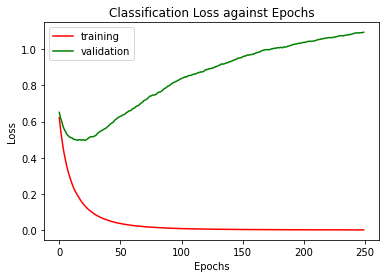

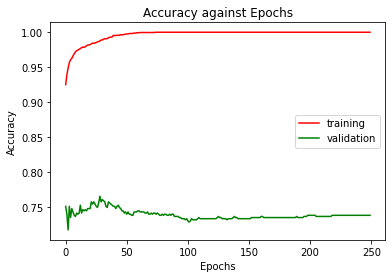

In [ ]:
# cv_results = xgb.fit_cv()[0]
xgb.fit()
xgb.plot_loss()
xgb.plot_accuracy()

#### 1st Hyparmeter Random GridSearch

In [ ]:
xgb.get_best_model()
print(f'Best Model: {xgb.best_model.best_params_}')
xgb.fit_best_model()

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Lowest Loss: -0.10774829154744658
Best model Parameters: {'subsample': 0.6, 'reg_lambda': 1, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}
Best Model: {'subsample': 0.6, 'reg_lambda': 1, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}


Train Accuracy:  1.0
Test Accuraccy:  0.7451923076923077

Confusion Matrix (Testing Dataset):
[[387   3]
 [156  78]]

Classification Report (Testing Dataset):
              precision    recall  f1-score   support

         0.0       0.71      0.99      0.83       390
         1.0       0.96      0.33      0.50       234

    accuracy                           0.75       624
   macro avg       0.84      0.66      0.66       624
weighted avg       0.81      0.75      0.70       624



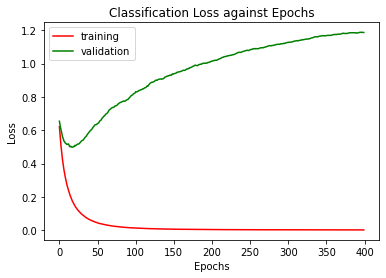

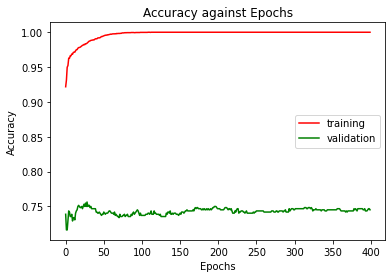

In [ ]:
xgb.plot_loss()
xgb.plot_accuracy()

#### 2nd Hyparmeter Random GridSearch

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Lowest Loss: 0.09415024301665677
Best model Parameters: {'subsample': 0.6, 'reg_lambda': 1.5, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.6, 'colsample_bytree': 0.76}


Best Model: {'subsample': 0.6, 'reg_lambda': 1.5, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.6, 'colsample_bytree': 0.76}


Train Accuracy:  1.0
Test Accuraccy:  0.7355769230769231

Confusion Matrix (Testing Dataset):
[[388   2]
 [163  71]]

Classification Report (Testing Dataset):
              precision    recall  f1-score   support

         0.0       0.70      0.99      0.82       390
         1.0       0.97      0.30      0.46       234

    accuracy                           0.74       624
   macro avg       0.84      0.65      0.64       624
weighted avg       0.80      0.74      0.69       624



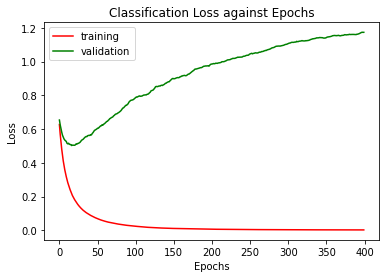

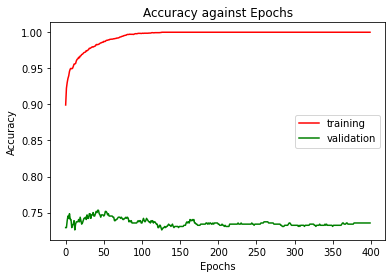

In [20]:
xgb.get_best_model(num_folds=3, n_iter=100)
print('\n')
print(f'Best Model: {xgb.best_model.best_params_}')

xgb.fit_best_model()
xgb.plot_loss()
xgb.plot_accuracy()